In [4]:
import random
import os, sys
from keras.models import Sequential
from keras.layers import InputLayer, Dense
import numpy as np
import matplotlib.pyplot as plt

if 'SUMO_HOME' in os.environ:
    tools = os.path.join(os.environ['SUMO_HOME'], 'tools')
    sys.path.append(tools)
else:
    sys.exit("please declare environment variable 'SUMO_HOME'")
    
from sumolib import checkBinary  # noqa
import traci  # noqa

In [5]:
def generate_routefile():
    random.seed(42)  # make tests reproducible
    N = 3600  # number of time steps
    # demand per second from different directions

    pEW = 1 / 10
    pNS = 1 / 40
    pWE = 1 / 10
    pSN = 1 / 40

    with open("cross.rou.xml", "w") as routes:
        print("""<routes>
        <vType id="car" accel="0.8" decel="4.5" sigma="0.5" length="5" minGap="2.5" maxSpeed="16.67" guiShape="passenger"/>
        <route id="right" edges="51o 1i 2o 52i" />
        <route id="left" edges="52o 2i 1o 51i" />
        <route id="down" edges="54o 4i 3o 53i" />
        <route id="up" edges="53o 3i 4o 54i" />""", file=routes)
        vehNr = 0
        for i in range(N):
            if random.uniform(0, 1) < pWE:
                print('    <vehicle id="right_%i" type="car" route="right" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
            if random.uniform(0, 1) < pEW:
                print('    <vehicle id="left_%i" type="car" route="left" depart="%i" />' % (
                    vehNr, i), file=routes)
                vehNr += 1
            if random.uniform(0, 1) < pNS:
                print('    <vehicle id="down_%i" type="car" route="up" depart="%i" color="1,0,0"/>' % (
                    vehNr, i), file=routes)
                vehNr += 1
            if random.uniform(0, 1) < pSN:
                print('    <vehicle id="UP_%i" type="car" route="down" depart="%i" color="1,0,0"/>' % (
                    vehNr, i), file=routes)
                vehNr += 1
        print("</routes>", file=routes)

def define_ANN():

    model = Sequential()
    model.add(InputLayer(batch_input_shape=(1, 9)))
    model.add(Dense(9, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])

    return model

def take_action(decision):
    if decision == 1:
        if traci.trafficlight.getPhase("0") == 0:
            traci.trafficlight.setPhase("0",1)
        elif traci.trafficlight.getPhase("0") == 2:
            traci.trafficlight.setPhase("0",3)
    else:
        pass



def get_state():

    state = np.zeros((1,9))

    lanes = ["4i_0","2i_0","3i_0","1i_0"]
    for i,lane in enumerate(lanes):

        state[0,i] = traci.lane.getLastStepHaltingNumber(lane)
        state[0,i+4] = traci.lane.getLastStepMeanSpeed(lane)

    state[0,8] = traci.trafficlight.getPhase("0")
    return state


def get_reward(state): 
    return -np.sum(state[0,0:4])


def run_NN():
    """execute the TraCI control loop"""

    # ANN
    model = define_ANN()

    # now execute the q learning
    y = 0.9                                                                        # how much to value future rewards (long-term max vs short-term max)
    eps = 0.2                                                                       # how much exploration
    decay_factor = 0.999                                                            # how much to lower exploration as learning goes on
    reward_avg_list = []                                                            # average reward collected
    num_episodes = 10
    for i in range(num_episodes):
        #state = env.reset()                                                         # when called, resets the environment
        
        sumo_cmd = [sumoBinary, 
                    '-n', cross.net.xml,
                    '-r' ,cross.rou.xml]
        traci.start([sumo_cmd])
        
        # reduces the exploration rate
        print("Episode {} of {}".format(i + 1, num_episodes))                       # print progress
        reward_sum = 0
        reward_hist =[]
        reward_evol = []                                                             # initialise reward sum
        step = 0
        traci.simulationStep(3)                                                    # Initialise simulation
        while traci.simulation.getMinExpectedNumber() > 0:                          # Run simulation until there is no more cars in the network
            eps *= decay_factor
            # Get current state
            state = get_state()

            # take action and get reward + new state
            if np.random.random() < eps:
                action = random.sample((1,0),1) # change TL (=1) keep current state (=0)
                take_action(action)    # randomly choose whether to explore or exploit choosing TL phase
            else:
                action = np.argmax(model.predict(state))  # choose action that maximises predicted reward
                take_action(action)

            traci.simulationStep(10*step)                                                # Simulation step 10 s

            new_state = get_state()
            reward = get_reward(new_state)

            target = reward + y * np.max(model.predict(new_state)) #
            target_vec = model.predict(state)[0]


            target_vec[action] = target

            model.fit(state, target_vec.reshape(-1, 2), epochs=1, verbose=0)
            state = new_state
            reward_sum += reward
            reward_hist.append(reward_sum)
            reward_evol.append(reward)
            step += 1

        
        reward_avg_list.append(reward_sum)
        traci.close()
    sys.stdout.flush()
    return reward_avg_list


def run_wo():
    """execute the TraCI control loop"""


    reward_avg_list = []                                                            # average reward collected
    num_episodes = 1
    for i in range(num_episodes):
        #state = env.reset()                                                         # when called, resets the environment
        #eps *= decay_factor                                                         # reduces the exploration rate
        print("Episode {} of {}".format(i + 1, num_episodes))                       # print progress
        reward_sum = 0
        reward_hist =[]
        reward_evol = []                                                             # initialise reward sum
        step = 0
        traci.simulationStep(10)                                                    # Initialise simulation
        while traci.simulation.getMinExpectedNumber() > 0:                          # Run simulation until there is no more cars in the network


            # Get current state

            traci.simulationStep(10*step)                                                # Simulation step 10 s

            new_state = get_state()
            reward = get_reward(new_state)

            reward_sum += reward
            reward_hist.append(reward_sum)
            reward_evol.append(reward)
            step += 1
        #r_avg_list.append(reward_sum / 100)

        return reward_hist

In [6]:
sumoBinary = checkBinary('sumo')

# first, generate the route file for this simulation
generate_routefile()

# this is the normal way of using traci. sumo is started as a
# subprocess and then the python script connects and runs
reward_hist_NN = run_NN()



traci.start([sumoBinary, "-c", "cross_no_RL.sumocfg",
                             "--tripinfo-output", "tripinfo.xml"])
reward_hist = run_wo()

traci.close()
sys.stdout.flush()

NameError: name 'cross' is not defined

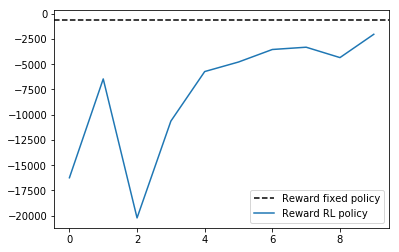

In [33]:
plt.axhline(y=np.mean(reward_hist), color = "black",linestyle = "--")
plt.plot(reward_hist_NN)
plt.legend(["Reward fixed policy","Reward RL policy"])